In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace, GenerationConfig
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
    generation_config=GenerationConfig(method='softmax_sampling', choices=16, top_p=0.9),
    n_restarts=32,
    parsimony=0.1,
    verbose=True,
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


In [4]:
demo_expression = [
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('0.1 * ((1.1 / x)**(12) - (1.2 / x)**6)', (0.1, 1.1, 1.2), (0.8, 2.5)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85)))', (5.3, 1, 0.72, 2.85), (-10, 10)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85))) + sin(1.5 * x)', (5.3, 1, 0.72, 2.85, 1.5), (-10, 10)),
][1]

In [5]:
expression, constants, xlim = demo_expression

In [6]:
prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [7]:
x = np.random.uniform(*xlim, 100)
y = demo_function(x)
if isinstance(y, float):
    y = np.full_like(x, y)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

# Pad the x_tensor with zeros to match the expected maximum input dimension of the set transformer
pad_length = nsr.flash_ansr_transformer.encoder_max_n_variables - x_tensor.shape[-1] - y_tensor.shape[-1]

if pad_length > 0:
    x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0), value=0)

data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)
print(data_tensor.shape)

torch.Size([100, 4])


In [8]:
beams, scores, is_valid = nsr.generate(data=data_tensor)

In [9]:
print(len(beams))

15


In [10]:
for beam, score, valid in zip(beams, scores, is_valid):
    print(beam)
    print(nsr.expression_space.tokenizer.decode(beam, special_tokens='<num>'))
    print(score)
    print(valid)
    print()
    break

[1, 24, 22, 29, 30, 2]
['tan', 'sin', 'log', 'x1']
-3.4488165080499584
True



In [11]:
nsr.generation_config = GenerationConfig(method='softmax_sampling', choices=128, verbose=True)

In [12]:
nsr.eval().fit(x_tensor, y_tensor)

Generating 128 sequences (max length: 32): 100%|██████████| 128/128 [00:00<00:00, 242.90it/s]


FlashANSR(expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7f4f1f07d350>,
          flash_ansr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_features=512, bias=True)...
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          generation_config={'choices': 128, 'verbose': True, 'top_k': 0, 'top_p': 1, 'max_len': 32, 'mini_batch_size': 128, 'temperature': 1, 'valid_only': True, 'simplify': True, 'unique': True},
          n_restarts=32, parsimony=0.1, verbose=True)

In [13]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,beam_id,fit_constants,fit_covariances,fit_loss
0,-17.301080,0.000538,-2.268995,"[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",10,None,None,"[1, 24, 22, 7, 6, 11, 6, 28, 11, 6, 30, 2]","[24, 22, 7, 6, 11, 6, 28, 11, 6, 30]","[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",<function <lambda> at 0x7f4f18b68360>,"Refiner(expression=['tan', 'sin', '+', '<num>'...",0,"[-2.0364034184566733, 4.6734882911422915, 0.99...","[[0.005260848727730238, -0.004430743051383352,...",0.000143
1,-17.301080,0.000538,-2.268995,"[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",10,None,None,"[1, 24, 22, 7, 6, 11, 6, 28, 11, 6, 30, 2]","[24, 22, 7, 6, 11, 6, 28, 11, 6, 30]","[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",<function <lambda> at 0x7f4f18b68360>,"Refiner(expression=['tan', 'sin', '+', '<num>'...",0,"[-2.03640336290168, 4.673488247616093, 0.99701...","[[0.005260845378166158, -0.004430740180094631,...",0.000143
2,-17.301080,0.000538,-2.268995,"[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",10,None,None,"[1, 24, 22, 7, 6, 11, 6, 28, 11, 6, 30, 2]","[24, 22, 7, 6, 11, 6, 28, 11, 6, 30]","[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",<function <lambda> at 0x7f4f18b68360>,"Refiner(expression=['tan', 'sin', '+', '<num>'...",0,"[-2.036403275531829, 4.6734881856111565, 0.997...","[[0.005260828940119754, -0.004430725411013952,...",0.000143
3,-17.301080,0.000538,-2.268995,"[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",10,None,None,"[1, 24, 22, 7, 6, 11, 6, 28, 11, 6, 30, 2]","[24, 22, 7, 6, 11, 6, 28, 11, 6, 30]","[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",<function <lambda> at 0x7f4f18b68360>,"Refiner(expression=['tan', 'sin', '+', '<num>'...",0,"[-2.036403161788762, 4.6734880970449, 0.997011...","[[0.005260820551610223, -0.0044307177704180295...",0.000143
4,-17.301080,0.000538,-2.268995,"[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",10,None,None,"[1, 24, 22, 7, 6, 11, 6, 28, 11, 6, 30, 2]","[24, 22, 7, 6, 11, 6, 28, 11, 6, 30]","[tan, sin, +, <num>, /, <num>, exp, /, <num>, x1]",<function <lambda> at 0x7f4f18b68360>,"Refiner(expression=['tan', 'sin', '+', '<num>'...",0,"[-2.036403101746207, 4.673488054545934, 0.9970...","[[0.005260810091154879, -0.004430708396413896,...",0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,-26.048418,NaN,NaN,"[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",15,None,None,"[1, 10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, ...","[10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, 10,...","[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",<function <lambda> at 0x7f4f8027a0c0>,"Refiner(expression=['*', '<num>', 'sin', '-', ...",104,"[-0.4605364756364597, 0.8640171230176104, 0.09...","[[inf, inf, inf, inf], [inf, inf, inf, inf], [...",NaN
3021,-26.048418,NaN,NaN,"[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",15,None,None,"[1, 10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, ...","[10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, 10,...","[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",<function <lambda> at 0x7f4f8027a0c0>,"Refiner(expression=['*', '<num>', 'sin', '-', ...",104,"[0.3002919051744902, 1.091915794803113, 1.3055...","[[inf, inf, inf, inf], [inf, inf, inf, inf], [...",NaN
3022,-26.048418,NaN,NaN,"[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",15,None,None,"[1, 10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, ...","[10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, 10,...","[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",<function <lambda> at 0x7f4f8027a0c0>,"Refiner(expression=['*', '<num>', 'sin', '-', ...",104,"[0.26711549748125524, -0.4483295585927525, -0....","[[inf, inf, inf, inf], [inf, inf, inf, inf], [...",NaN
3023,-26.048418,NaN,NaN,"[*, <num>, sin, -, <num>, /, x1, +, <num>, exp...",15,None,None,"[1, 10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, ...","[10, 6, 22, 8, 6, 11, 30, 7, 6, 28, 9, 25, 10,...","[*, <num>, sin, -, <num>, /, x1, 

# Training loop

In [ ]:
HYPERPARAMS = {
    'n_restarts': 32,
    'parsimony': 0.1,
    'lr': 5e-5,
    'n_steps': 1000,
    'method': 'softmax_sampling',
    'choices': 128,
    'top_p': 0.9,
    'top_k': 0,
    'temperature': 1.0,
    'priority_queue_size': 16,
    'entropy_weight': 0.01,
}

In [14]:
from flash_ansr.train.train import OptimizerFactory

In [15]:
optimizer = OptimizerFactory.get_optimizer('AdamWScheduleFree', nsr.flash_ansr_transformer.parameters(), lr=5e-5, weight_decay=0.01)

In [16]:
nsr.generation_config = GenerationConfig(method='softmax_sampling', choices=128, top_p=0.99, temperature=2)

priority_queue_size = 16
entropy_weight = 0.01

In [17]:
nsr.flash_ansr_transformer.eval()
nsr.fit(x_tensor, y_tensor)

FlashANSR(expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7f4f1f07d350>,
          flash_ansr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_features=512, bias=True)...
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          generation_config={'choices': 64, 'top_p': 0.99, 'temperature': 2, 'top_k': 0, 'max_len': 32, 'mini_batch_size': 128, 'valid_only': True, 'simplify': True, 'unique': True},
          n_restarts=32, parsimony=0.1, verbose=True)

In [18]:
history = []
pbar = tqdm(range(100))

beam_samples = []
reward_samples = []


for _ in pbar:
    try:
        # Generate sequences and evaluate
        nsr.flash_ansr_transformer.eval()
        nsr.fit(x_tensor, y_tensor)
        fvu_stats = {'mean': [], 'max': [], 'min': []}
        
        for _, df in nsr.results.groupby('beam_id'):
            if not np.isfinite(df['fvu']).any():
                continue
            new_beam_candidate = tuple(df['raw_beam'].iloc[0])
            if new_beam_candidate in beam_samples:
                continue
            beam_samples.append(new_beam_candidate)
            # reward_samples.append(np.nanmedian(np.log10(df['fvu'])))
            reward_samples.append(np.nanmedian(df['score']))
            fvu_stats['mean'].append(np.mean(df['fvu']))
            fvu_stats['max'].append(np.max(df['fvu']))
            fvu_stats['min'].append(np.min(df['fvu']))

        # Sort by reward
        sorted_indices = np.argsort(reward_samples)
        beam_samples = [beam_samples[i] for i in sorted_indices][:priority_queue_size]
        reward_samples = [reward_samples[i] for i in sorted_indices][:priority_queue_size]

        max_queue_objective = max(reward_samples)
        min_queue_objective = min(reward_samples)
        
        # Padding sequences to same length
        max_length = max(len(beam) for beam in beam_samples)
        padded_beams = [list(beam) + [nsr.expression_space.tokenizer['<pad>']] * (max_length - len(beam)) for beam in beam_samples]
        
        beam_tensor = torch.tensor(padded_beams, dtype=torch.long).to(device)
        
        # Train with REINFORCE
        nsr.flash_ansr_transformer.train()
        optimizer.train()
        optimizer.zero_grad()
        
        logits, _ = nsr.flash_ansr_transformer.forward(
            beam_tensor, 
            data_tensor.unsqueeze(0).repeat(len(beam_samples), 1, 1)
        )
        log_probs = torch.log_softmax(logits, dim=-1)
        
        # Get log probs for actions taken
        taken_log_probs = log_probs.gather(2, beam_tensor[:, 1:].unsqueeze(-1)).squeeze(-1)
        
        # Compute masks for padding and sequence endings
        pad_mask = beam_tensor != nsr.expression_space.tokenizer['<pad>']
        
        # Increase average log likelihood (not weighted by reward)
        policy_loss = -torch.mean(taken_log_probs[pad_mask[:, 1:]])
        
        # Average loss over batch
        policy_loss /= len(beam_samples)

        # Regularize the entropy of the taken actions (tokens) and ignore padding
        entropy = - torch.sum(torch.exp(log_probs) * log_probs, dim=-1) * pad_mask
        entropy = torch.mean(entropy)

        loss = policy_loss - entropy_weight * entropy
        
        # Backprop and update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nsr.flash_ansr_transformer.parameters(), 10.0)
        optimizer.step()
        
        logs = {
            'policy_gradient_loss': policy_loss.item(),
            'entropy': entropy.item(),
            'max_queue_objective': max_queue_objective,
            'min_queue_objective': min_queue_objective,
            'fvu_mean': np.nanmean(fvu_stats['mean']),
            'fvu_max': np.nanmax(fvu_stats['max']),
            'fvu_min': np.nanmin(fvu_stats['min']),
        }
    
    except ConvergenceError:
        logs = {
            'policy_gradient_loss': np.nan,
            'entropy': np.nan,
            'max_queue_objective': np.nan,
            'min_queue_objective': np.nan,
            'fvu_mean': np.nan,
            'fvu_max': np.nan,
            'fvu_min': np.nan,
        }
    
    history.append(logs)
    pbar.set_postfix_str(f"PG Loss: {logs['policy_gradient_loss']:.2e}, H Loss: {logs['entropy']:.2e}, Max PQ Score: {logs['max_queue_objective']:.1f}, Min PQ Score: {logs['min_queue_objective']:.1f}, Min FVU: {logs['fvu_min']:.2e}, Best Expression: {nsr.expression_space.prefix_to_infix(nsr.expression_space.tokenizer.decode(beam_samples[0], special_tokens='<num>'))}")

 72%|███████▏  | 72/100 [02:53<01:07,  2.41s/it, PG Loss: 5.36e-02, H Loss: 8.47e-01, Max PQ Score: -3.0, Min PQ Score: -4.6, Min FVU: 1.78e-03, Best Expression: (<num> - (x1 + (<num> / exp(neg(atan(<num> + pow1_5(x1)) * tan(inv(<num> * x1))))))) / <num>]    


KeyboardInterrupt: 

In [19]:
# history = []
# pbar = tqdm(range(1000))

# for _ in pbar:
#     try:
#         # Generate sequences and evaluate
#         nsr.flash_ansr_transformer.eval()
#         nsr.fit(x_tensor, y_tensor)
        
#         beam_samples = []
#         rewards = []
#         fvu_stats = {'mean': [], 'max': [], 'min': []}
        
#         for _, df in nsr.results.groupby('beam_id'):
#             beam_samples.append(best_fit_of_beam['raw_beam'])
#             rewards.append(1 / (1 + np.median(df['fvu'])))
#             fvu_stats['mean'].append(np.mean(df['fvu']))
#             fvu_stats['max'].append(np.max(df['fvu']))
#             fvu_stats['min'].append(np.min(df['fvu']))
        
#         # Padding sequences to same length
#         max_length = max(len(beam) for beam in beam_samples)
#         padded_beams = [beam + [nsr.expression_space.tokenizer['<pad>']] * (max_length - len(beam)) for beam in beam_samples]
        
#         beam_tensor = torch.tensor(padded_beams, dtype=torch.long).to(device)
#         reward_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
        
#         # Handle any invalid rewards
#         reward_tensor = torch.where(torch.isfinite(reward_tensor), reward_tensor, torch.zeros_like(reward_tensor))
        
#         # Calculate baseline (optional, but recommended)
#         baseline = reward_tensor.mean()
        
#         # Train with REINFORCE
#         nsr.flash_ansr_transformer.train()
#         optimizer.train()
#         optimizer.zero_grad()
        
#         logits, _ = nsr.flash_ansr_transformer.forward(
#             beam_tensor, 
#             data_tensor.unsqueeze(0).repeat(len(beam_samples), 1, 1)
#         )
#         log_probs = torch.log_softmax(logits, dim=-1)
        
#         # Get log probs for actions taken
#         token_log_probs = log_probs.gather(2, beam_tensor[:, 1:].unsqueeze(-1)).squeeze(-1)
        
#         # Compute masks for padding and sequence endings
#         pad_mask = beam_tensor[:, 1:] != nsr.expression_space.tokenizer['<pad>']
        
#         # Initialize loss
#         policy_loss = torch.tensor(0.0).to(device)
        
#         # For each sequence
#         for i in range(len(beam_samples)):
#             seq_log_probs = token_log_probs[i] * pad_mask[i]
#             seq_len = pad_mask[i].sum()
            
#             # Find EOS position or use sequence length if no EOS
#             eos_pos = (beam_tensor[i] == nsr.expression_space.tokenizer['<eos>']).nonzero()
#             eos_pos = eos_pos[0].item() if len(eos_pos) > 0 else seq_len
            
#             # Calculate discounted rewards for each position
#             seq_reward = reward_tensor[i] - baseline  # Using baseline to reduce variance
            
#             # Accumulate loss with proper discounting
#             for t in range(eos_pos):
#                 discount = discount_factor ** (eos_pos - t - 1)
#                 policy_loss -= seq_log_probs[t] * seq_reward * discount
        
#         # Average loss over batch
#         policy_loss /= len(beam_samples)
        
#         # Backprop and update
#         policy_loss.backward()
#         torch.nn.utils.clip_grad_norm_(nsr.flash_ansr_transformer.parameters(), 10.0)
#         optimizer.step()
        
#         logs = {
#             'policy_gradient_loss': policy_loss.item(),
#             'reward_mean': reward_tensor.mean().item(),
#             'reward_max': reward_tensor.max().item(),
#             'reward_min': reward_tensor.min().item(),
#             'fvu_mean': np.nanmean(fvu_stats['mean']),
#             'fvu_max': np.nanmax(fvu_stats['max']),
#             'fvu_min': np.nanmin(fvu_stats['min']),
#         }
    
#     except ConvergenceError:
#         logs = {
#             'policy_gradient_loss': np.nan,
#             'reward_mean': np.nan,
#             'reward_max': np.nan,
#             'reward_min': np.nan,
#             'fvu_mean': np.nan,
#             'fvu_max': np.nan,
#             'fvu_min': np.nan,
#         }
    
#     history.append(logs)
#     pbar.set_postfix(logs)

In [19]:
histories = {k: [log[k] for log in history] for k in history[0]}

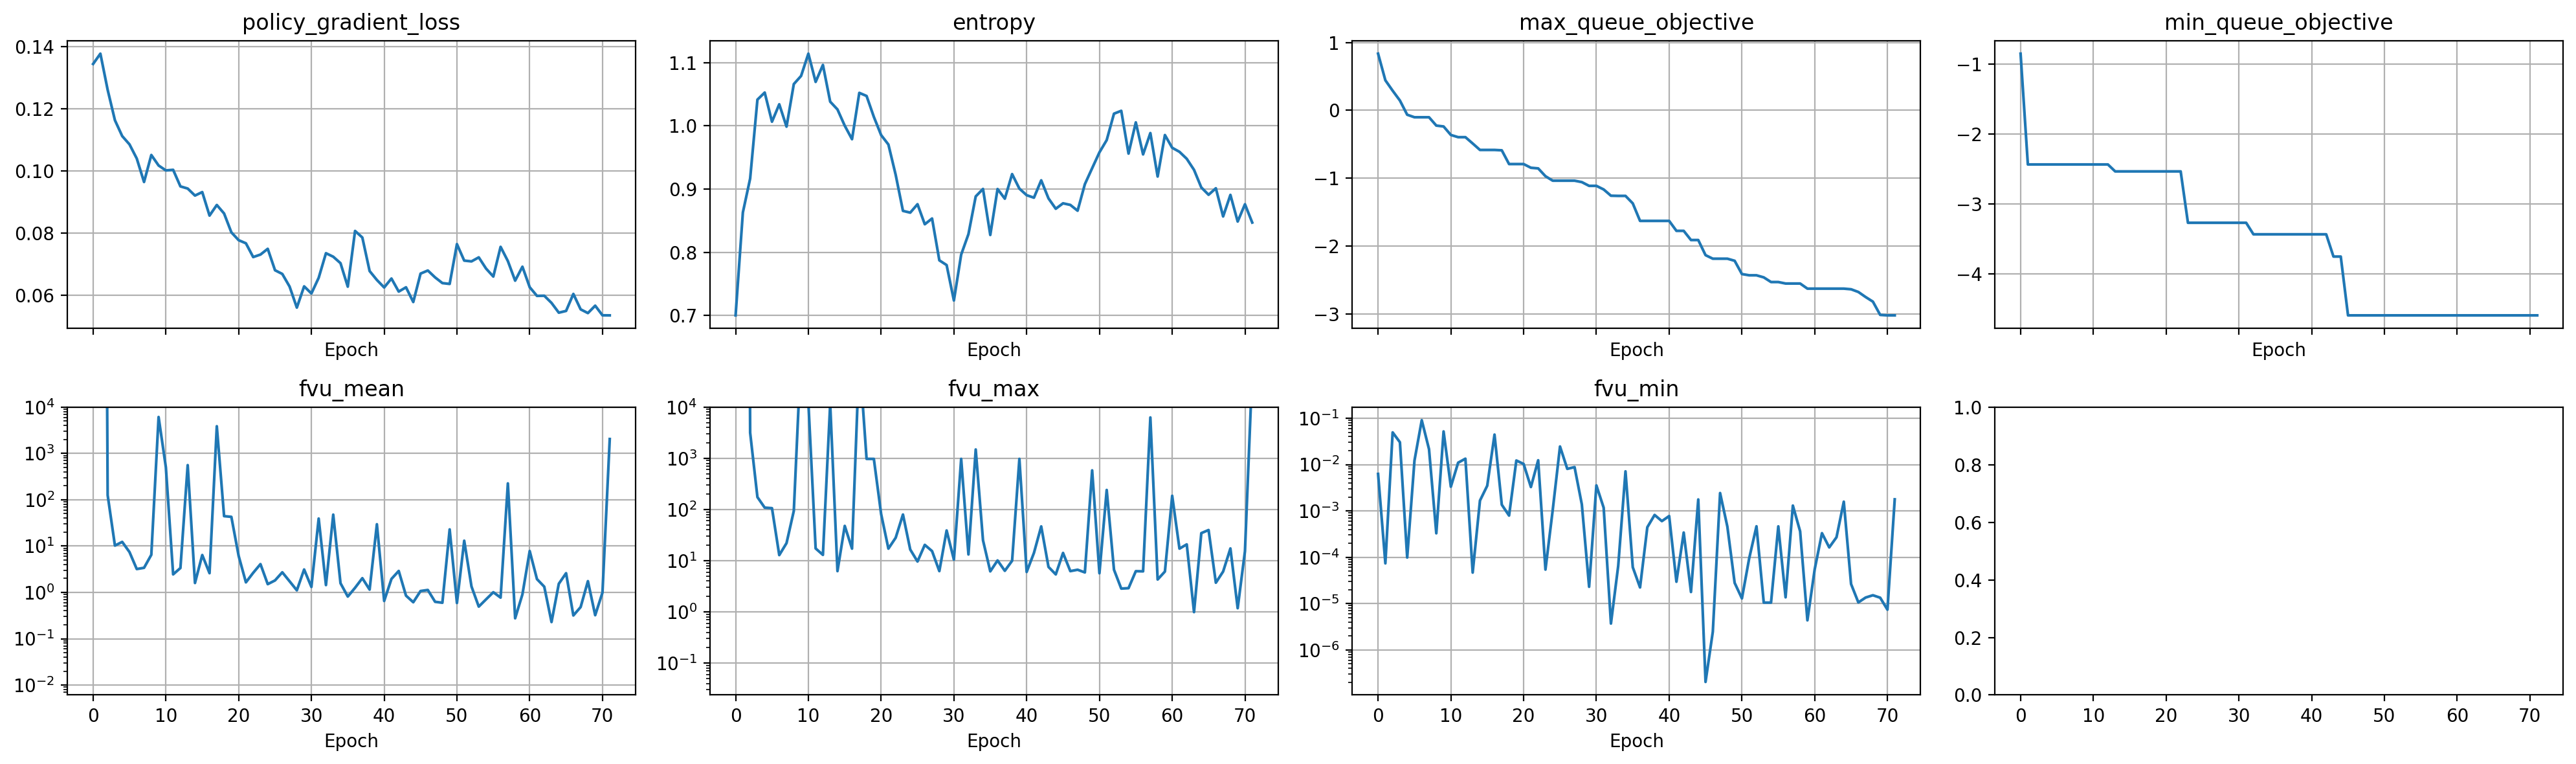

In [ ]:
COLS = 4
ROWS = np.ceil(len(histories) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 3 * ROWS), dpi=200, sharex=True)

for ax, (k, v) in zip(axes.flat, histories.items()):
    valid_v = [x for x in v if np.isfinite(x)]
    ax.plot(range(len(v)), v)
    ax.set_xlabel('Epoch')
    ax.set_title(k)
    ax.grid()

    if 'fvu' in k:
        ax.set_yscale('log')

    if max(valid_v) > 10000:
        ax.set_ylim(None, 10000)

fig.tight_layout()

In [21]:
nsr.generation_config = GenerationConfig(method='beam_search', beam_width=128, verbose=True)
# nsr.generation_config = GenerationConfig(method='softmax_sampling', choices=128, top_p=0.9, verbose=True)

In [22]:
nsr.eval().fit(x_tensor, y_tensor)

Generating beams (max length: 32): 100%|██████████| 32/32 [00:05<00:00,  5.68it/s, completed=253, pruned=0]


FlashANSR(expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7f55ee2e8e10>,
          flash_ansr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_features=512, bias=True)...
    (3): Linear(in_features=512, out_features=33, bias=True)
  )
  (num_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          generation_config={'beam_width': 128, 'verbose': True, 'max_len': 32, 'mini_batch_size': 128, 'equivalence_pruning': True},
          n_restarts=32, parsimony=0.1, verbose=True)

In [23]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,beam_id,fit_constants,fit_covariances,fit_loss
0,-7.040481,6.349752e-07,-4.497243,"[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",17,None,None,"[1, 10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6...","[10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6, 1...","[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",<function <lambda> at 0x7f55334016c0>,"Refiner(expression=['*', '<num>', 'cos', '*', ...",0,"[-1.5608197573895342, -0.5184922529209868, -20...","[[5.8162169701056375e-09, 2.268970456776257e-0...",1.802681e-07
1,-7.040481,6.349752e-07,-4.497243,"[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",17,None,None,"[1, 10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6...","[10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6, 1...","[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",<function <lambda> at 0x7f55334016c0>,"Refiner(expression=['*', '<num>', 'cos', '*', ...",0,"[1.5595257988786324, 0.7000371096727551, -220....","[[7.520229926662039e-08, 3.2703539599776153e-0...",1.988802e-06
2,-7.040481,6.349752e-07,-4.497243,"[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",17,None,None,"[1, 10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6...","[10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6, 1...","[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",<function <lambda> at 0x7f55334016c0>,"Refiner(expression=['*', '<num>', 'cos', '*', ...",0,"[1.559525798443332, 0.7000370993577696, -165.8...","[[7.519942747207527e-08, 3.245785820189297e-07...",1.988802e-06
3,-7.040481,6.349752e-07,-4.497243,"[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",17,None,None,"[1, 10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6...","[10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6, 1...","[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",<function <lambda> at 0x7f55334016c0>,"Refiner(expression=['*', '<num>', 'cos', '*', ...",0,"[1.5595258006298494, 0.700037116808241, 275.76...","[[7.589958603237783e-08, 3.359541960857328e-07...",1.988802e-06
4,-7.040481,6.349752e-07,-4.497243,"[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",17,None,None,"[1, 10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6...","[10, 6, 23, 10, 6, 29, 7, 6, 7, 6, 14, 7, 6, 1...","[*, <num>, cos, *, <num>, log, +, <num>, +, <n...",<function <lambda> at 0x7f55334016c0>,"Refiner(expression=['*', '<num>', 'cos', '*', ...",0,"[-1.559024196098831, -0.48526328941499886, -93...","[[9.207782778932189e-08, 1.305836365858584e-07...",2.696181e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3068,-7.060420,NaN,NaN,"[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",17,None,None,"[1, 7, 6, 10, 6, 23, 10, 6, 29, 7, 6, 14, 7, 6...","[7, 6, 10, 6, 23, 10, 6, 29, 7, 6, 14, 7, 6, 1...","[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",<function <lambda> at 0x7f55231205e0>,"Refiner(expression=['+', '<num>', '*', '<num>'...",127,"[-1.634436258006021, -0.26319717990466934, 0.5...","[[inf, inf, inf, inf, inf, inf], [inf, inf, in...",NaN
3069,-7.060420,NaN,NaN,"[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",17,None,None,"[1, 7, 6, 10, 6, 23, 10, 6, 29, 7, 6, 14, 7, 6...","[7, 6, 10, 6, 23, 10, 6, 29, 7, 6, 14, 7, 6, 1...","[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",<function <lambda> at 0x7f55231205e0>,"Refiner(expression=['+', '<num>', '*', '<num>'...",127,"[-0.2953821824374804, 0.1819907852525694, 0.58...","[[inf, inf, inf, inf, inf, inf], [inf, inf, in...",NaN
3070,-7.060420,NaN,NaN,"[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",17,None,None,"[1, 7, 6, 10, 6, 23, 10, 6, 29, 7, 6, 14, 7, 6...","[7, 6, 10, 6, 23, 10, 6, 29, 7, 6, 14, 7, 6, 1...","[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",<function <lambda> at 0x7f55231205e0>,"Refiner(expression=['+', '<num>', '*', '<num>'...",127,"[-0.6211022058382135, 1.162181239807858, -0.01...","[[1404098355248.037, -1404098599330.089, -6969...",6.036267e-01
3071,-7.060420,NaN,NaN,"[+, <num>, *, <num>, cos, *, <num>, log, +, <n...",17,None,Non

In [24]:
nsr.get_expression()

'-1.56 * cos(-0.52 * log(-201.77 + (99.67 + pow2(10.42 + pow2(-0.39 + x1)))))'

In [25]:
demo_expression[0]

'-x + log(x + x**4)'

In [37]:
x_linspace = np.linspace(*xlim, 1000)
y_linspace_pred = nsr.predict(x_linspace.reshape(-1, 1))

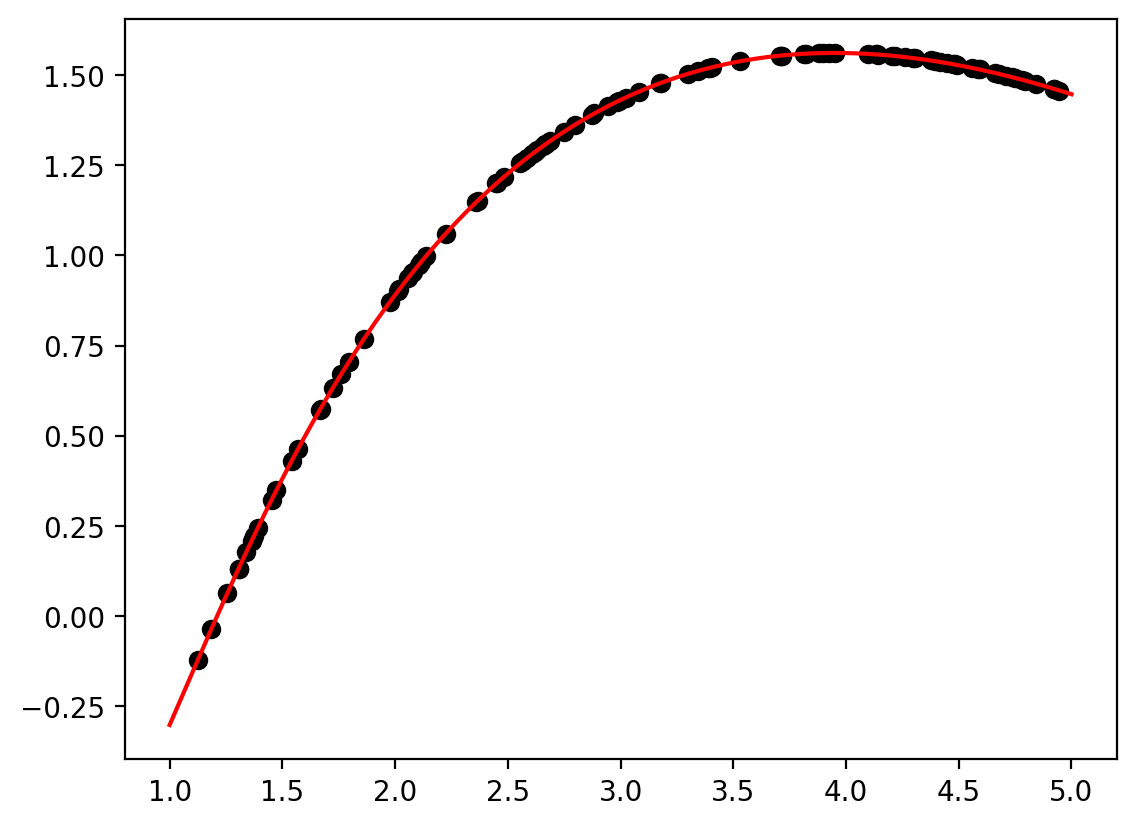

In [38]:
fig, ax = plt.subplots(dpi=200)

ax.scatter(x, y, label='Data', color='black')
ax.plot(x_linspace, y_linspace_pred, label='Prediction', color='red')